In [1]:
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.plot import plot_ofat, plot_ofat_final_step
from scipy.stats import norm

/opt/homebrew/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Analysis

In [55]:
model_data = pd.read_csv('../results/default_model_results.csv')
vary_sentence_data = pd.read_csv('../results/vary_sentence_length_results.csv')

In [24]:
agent_data = pd.read_csv('../results/default_agent_results.csv')

In [45]:
agent_df = agent_data.groupby('iteration').mean().reset_index()

In [86]:
agent_data.head()

,wealth,num_been_crimed,trading_skill,risk_aversion,num_interactions,total_trading_gain,starting_wealth,amount_arrested,total_stealing_gain,crimes_committed_agent,iteration
0,5.541628,0.0,1.044212,1.040036,0.0,0.0,5.654722,0.0,0.000000,0.0,1
1,3.029026,1.0,0.680330,1.058948,1.0,0.0,6.181685,0.0,0.000000,0.0,1
2,5.326652,1.0,0.742898,0.849384,2.0,0.0,6.395091,0.0,4.475627,1.0,1
3,3.319608,1.0,0.796657,1.190074,1.0,0.0,6.774710,0.0,0.000000,0.0,1
4,3.029516,1.0,0.677552,1.049027,1.0,0.0,6.182685,0.0,0.000000,0.0,1


In [136]:
agent_data['risk_aversion'].max()

2.192814798122498

/var/folders/t0/9lmj5c1904g_2_gp5sk6gz180000gn/T/ipykernel_50294/2174705143.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_agent['trading_skill_binned'] = gini_bins
/var/folders/t0/9lmj5c1904g_2_gp5sk6gz180000gn/T/ipykernel_50294/2174705143.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_agent['risk_aversion_binned'] = risk_aversion_std_bins
/var/folders/t0/9lmj5c1904g_2_gp5sk6gz180000gn/T/ipykernel_50294/2174705143.py:11: FutureWarning: The default value of observed=False is deprec

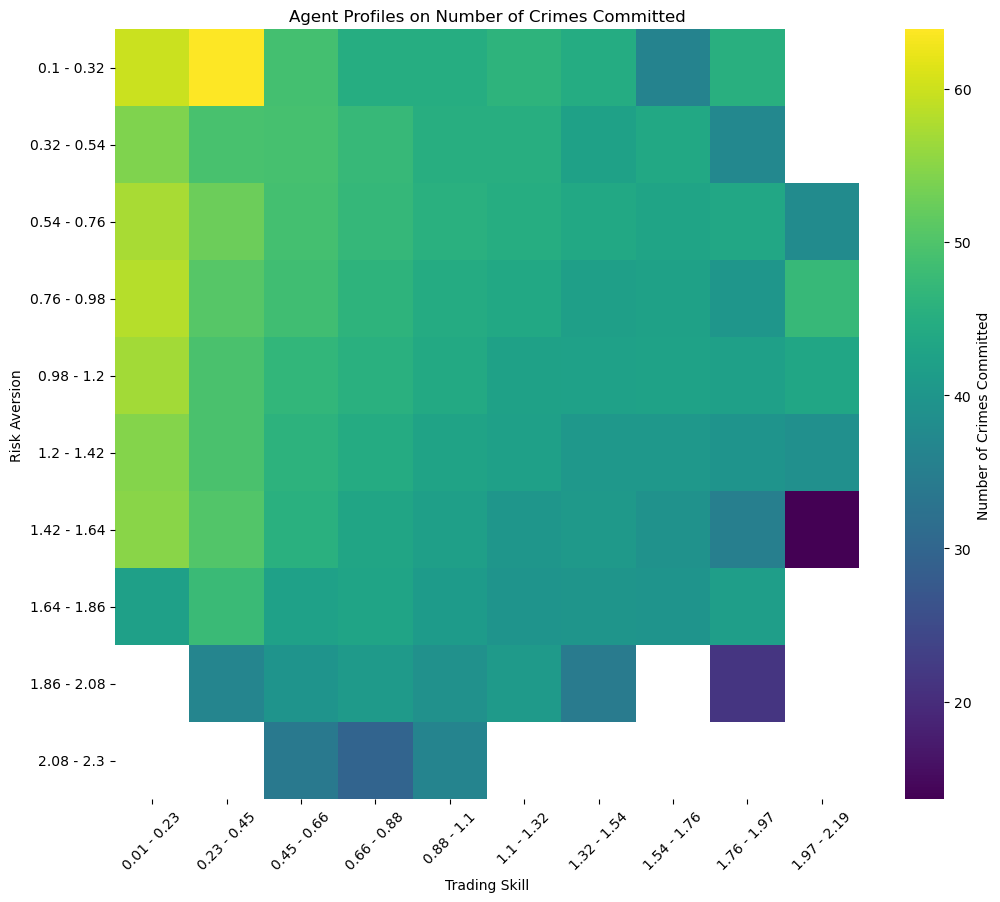

In [131]:
heatmap_agent = agent_data[['trading_skill', 'risk_aversion', 'crimes_committed_agent']]

# Bin the data for the heatmap
gini_bins = pd.cut(heatmap_agent['trading_skill'], bins=10)
risk_aversion_std_bins = pd.cut(heatmap_agent['risk_aversion'], bins=10)

heatmap_agent['trading_skill_binned'] = gini_bins
heatmap_agent['risk_aversion_binned'] = risk_aversion_std_bins

# Create a pivot table for the heatmap
heatmap_data = heatmap_agent.pivot_table(values='crimes_committed_agent', 
                                      index='trading_skill_binned', 
                                      columns='risk_aversion_binned', 
                                      aggfunc=np.mean)

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_data, cmap='viridis', annot=False, fmt=".1f", cbar_kws={'label': 'Number of Crimes Committed'})
plt.title('Agent Profiles on Number of Crimes Committed')
plt.xlabel('Trading Skill')
plt.ylabel('Risk Aversion')

# Update the axis labels with bin ranges
gini_labels = [f"{round(bin.left, 2)} - {round(bin.right, 2)}" for bin in heatmap_data.index.categories]
risk_aversion_std_labels = [f"{round(bin.left, 2)} - {round(bin.right, 2)}" for bin in heatmap_data.columns.categories]

plt.xticks(ticks=np.arange(len(risk_aversion_std_labels))+0.5, labels=risk_aversion_std_labels, rotation=45)
plt.yticks(ticks=np.arange(len(gini_labels))+0.5, labels=gini_labels, rotation=0)
plt.show()

In [89]:
trading_skill_agents = agent_data.groupby('iteration')['trading_skill'].std().reset_index()
trading_skill_agents.columns = ['iteration', 'trading_skill_agents']

In [90]:
model_data_at_last_step = model_data[model_data['Step'] == 500]

In [91]:
model_df = model_data_at_last_step.merge(trading_skill_agents, on='iteration', how='left')

In [92]:
model_df

,Step,num_cops,num_crimes_committed,num_arrests_made,tax_rate,total_stolen,total_trade_income,avg_wealth,total_wealth,avg_crime_perception,...,initial_cops,width,height,election_frequency,sentence_length,interaction_memory,risk_aversion_std,trading_skill_std,tax_per_cop,trading_skill_agents
0,500,9,25088,604,0.09,19802.941999,1200.871259,0.085054,17.010736,0.1407,...,2,20,20,70,20,50,0.3,0.3,0.01,0.297432
1,500,9,26922,609,0.09,20168.481198,1343.948749,0.083680,16.736086,0.1135,...,2,20,20,70,20,50,0.3,0.3,0.01,0.294820
2,500,9,28082,612,0.09,18518.378902,1043.417431,0.093908,18.781543,0.1183,...,2,20,20,70,20,50,0.3,0.3,0.01,0.298012
3,500,9,25368,588,0.09,19427.956203,1217.098001,0.088899,17.779758,0.1397,...,2,20,20,70,20,50,0.3,0.3,0.01,0.286443
4,500,9,27206,597,0.09,19399.127998,1121.423688,0.085376,17.075208,0.1362,...,2,20,20,70,20,50,0.3,0.3,0.01,0.309809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,500,9,28984,610,0.09,20925.743975,1023.420109,0.089539,17.907880,0.0974,...,2,20,20,70,20,50,0.3,0.3,0.01,0.292115
196,500,9,27506,639,0.09,16685.665703,1033.580399,0.108697,21.739468,0.1195,...,2,20,20,70,20,50,0.3,0.3,0.01,0.312286
197,500,9,28066,622,0.09,19883.625989,1165.751968,0.113250,22.650098,0.1274,...,2,20,20,70,20,50,0.3,0.3,0.01,0.300623
198,500,9,28118,614,0.09,19359.893982,1108.270309,0.072767,14.553363,0.1169,...,2,20,20,70,20,50,0.3,0.3,0.01,0.282785


/var/folders/t0/9lmj5c1904g_2_gp5sk6gz180000gn/T/ipykernel_50294/3952103497.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_df['gini_coeff_binned'] = gini_bins
/var/folders/t0/9lmj5c1904g_2_gp5sk6gz180000gn/T/ipykernel_50294/3952103497.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_df['trading_skill_agents_binned'] = risk_aversion_std_bins
/var/folders/t0/9lmj5c1904g_2_gp5sk6gz180000gn/T/ipykernel_50294/3952103497.py:11: FutureWarning: The default value of observed=False is deprecat

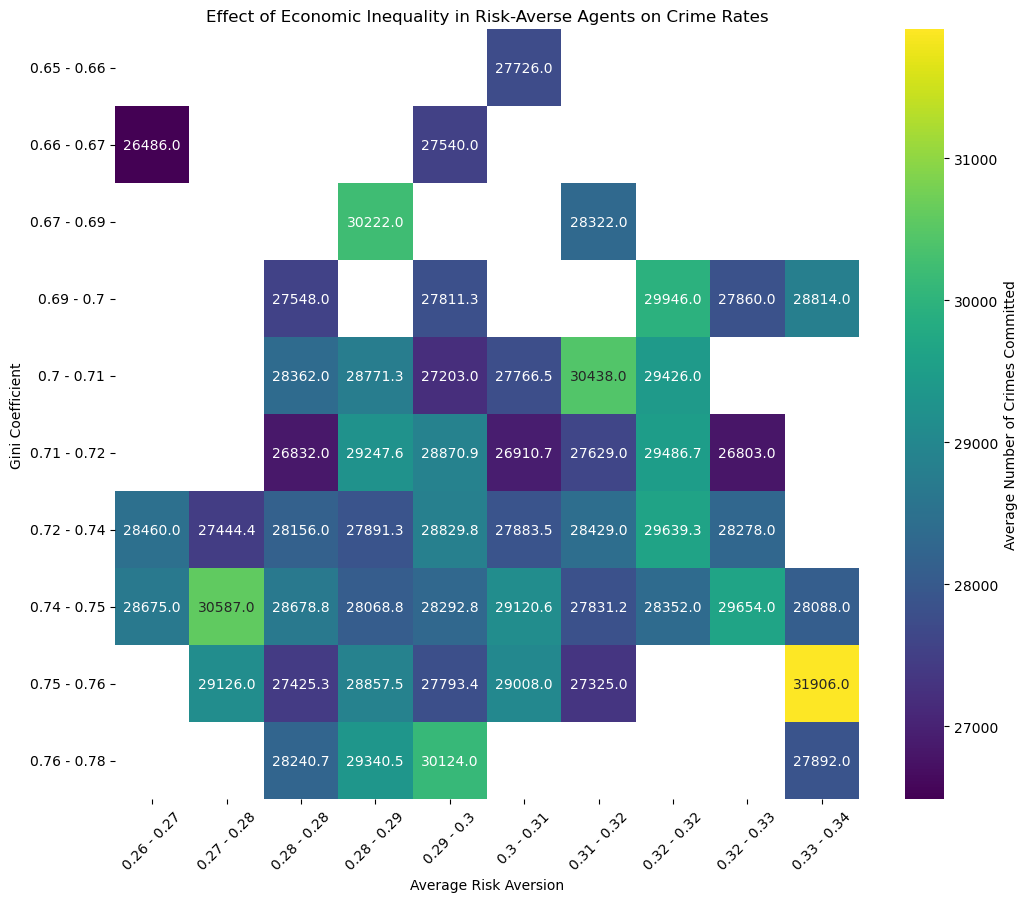

In [93]:
heatmap_df = model_df[['gini_coeff', 'trading_skill_agents', 'num_crimes_committed']]

# Bin the data for the heatmap
gini_bins = pd.cut(heatmap_df['gini_coeff'], bins=10)
risk_aversion_std_bins = pd.cut(heatmap_df['trading_skill_agents'], bins=10)

heatmap_df['gini_coeff_binned'] = gini_bins
heatmap_df['trading_skill_agents_binned'] = risk_aversion_std_bins

# Create a pivot table for the heatmap
heatmap_data = heatmap_df.pivot_table(values='num_crimes_committed', 
                                      index='gini_coeff_binned', 
                                      columns='trading_skill_agents_binned', 
                                      aggfunc=np.mean)

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt=".1f", cbar_kws={'label': 'Average Number of Crimes Committed'})
plt.title('Effect of Economic Inequality in Risk-Averse Agents on Crime Rates')
plt.xlabel('Average Risk Aversion')
plt.ylabel('Gini Coefficient')

# Update the axis labels with bin ranges
gini_labels = [f"{round(bin.left, 2)} - {round(bin.right, 2)}" for bin in heatmap_data.index.categories]
risk_aversion_std_labels = [f"{round(bin.left, 2)} - {round(bin.right, 2)}" for bin in heatmap_data.columns.categories]

plt.xticks(ticks=np.arange(len(risk_aversion_std_labels))+0.5, labels=risk_aversion_std_labels, rotation=45)
plt.yticks(ticks=np.arange(len(gini_labels))+0.5, labels=gini_labels, rotation=0)
plt.show()

### Overlay plot of crime reduction
Crime rates under different sentence lengths and number of cops

In [6]:
final_grouped = vary_sentence_data.groupby(['sentence_length', 'Step']).agg({
    'num_arrests_made': ['mean', 'std'],
    'num_crimes_committed': ['mean', 'std']
}).reset_index()
final_grouped.columns = ['_'.join(col).strip() if col[1] else col[0] for col in final_grouped.columns.values]
final_grouped

,sentence_length,Step,num_arrests_made_mean,num_arrests_made_std,num_crimes_committed_mean,num_crimes_committed_std
0,5,1,1.100,1.172331,150.70,12.208026
1,5,2,3.800,2.197901,298.45,17.087932
2,5,3,5.675,2.692701,441.85,18.654140
3,5,4,7.800,3.495051,582.50,22.448802
4,5,5,9.550,3.594511,718.85,23.195435
...,...,...,...,...,...,...
4995,90,496,241.350,7.430188,14943.95,1167.446961
4996,90,497,241.525,7.595503,14957.55,1167.840302
4997,90,498,241.875,7.666736,14972.60,1168.693963
4998,90,499,242.250,7.611563,14986.30,1171.122324


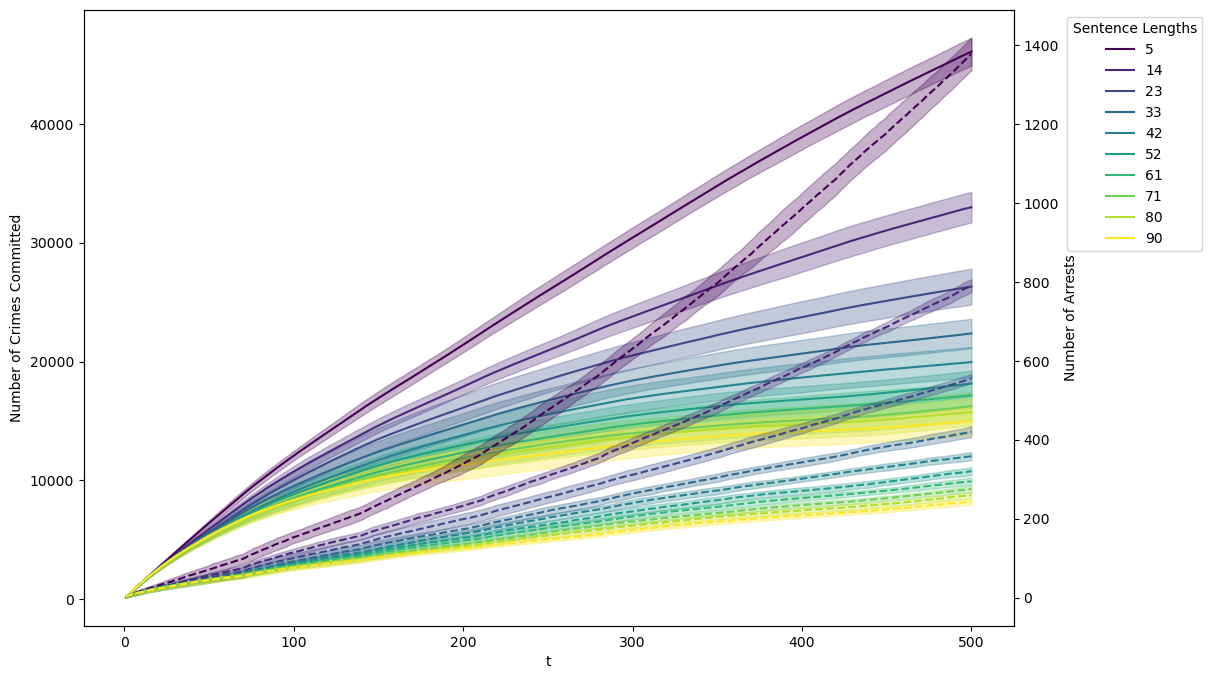

In [7]:
fig, ax1 = plt.subplots(figsize=(12, 8))

colors = plt.cm.viridis(np.linspace(0, 1, len(vary_sentence_data['sentence_length'].unique())))

# Create a second y-axis for the number of cops
ax2 = ax1.twinx()

# Plotting
for idx, (sentence_length, color) in enumerate(zip(sorted(vary_sentence_data['sentence_length'].unique()), colors)):
    subset = final_grouped[final_grouped['sentence_length'] == sentence_length]

    # Line plot for number of crimes committed with std fill
    mean_crimes = subset['num_crimes_committed_mean']
    std_crimes = subset['num_crimes_committed_std']
    ax1.plot(subset['Step'], mean_crimes, label=f'{sentence_length}', color=color)
    ax1.fill_between(subset['Step'], mean_crimes - std_crimes, mean_crimes + std_crimes, color=color, alpha=0.3)
    
    # Line plot for number of cops with std fill on second y-axis
    mean_cops = subset['num_arrests_made_mean']
    std_cops = subset['num_arrests_made_std']
    ax2.plot(subset['Step'], mean_cops, label=f'Sentence Length {sentence_length}', linestyle='--', color=color)
    ax2.fill_between(subset['Step'], mean_cops - std_cops, mean_cops + std_cops, color=color, alpha=0.3)

ax1.set_xlabel('t')
ax1.set_ylabel('Number of Crimes Committed')
ax2.set_ylabel('Number of Arrests')
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='upper left', bbox_to_anchor=(1.05, 1), title="Sentence Lengths")

plt.show()

In [11]:
default_data = pd.read_csv('../results/default_model_results.csv')

In [12]:
data_at_last_step = default_data[default_data['Step'] == 500]
columns_to_plot = ['num_crimes_committed', 'num_cops', 'gini_coeff', 'total_wealth']
labels = {
    'num_crimes_committed': 'Crimes Committed',
    'num_cops': 'Number of Cops',
    'gini_coeff': 'Gini Coefficient',
    'total_wealth': 'Population Wealth'
}

/opt/homebrew/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:1983: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


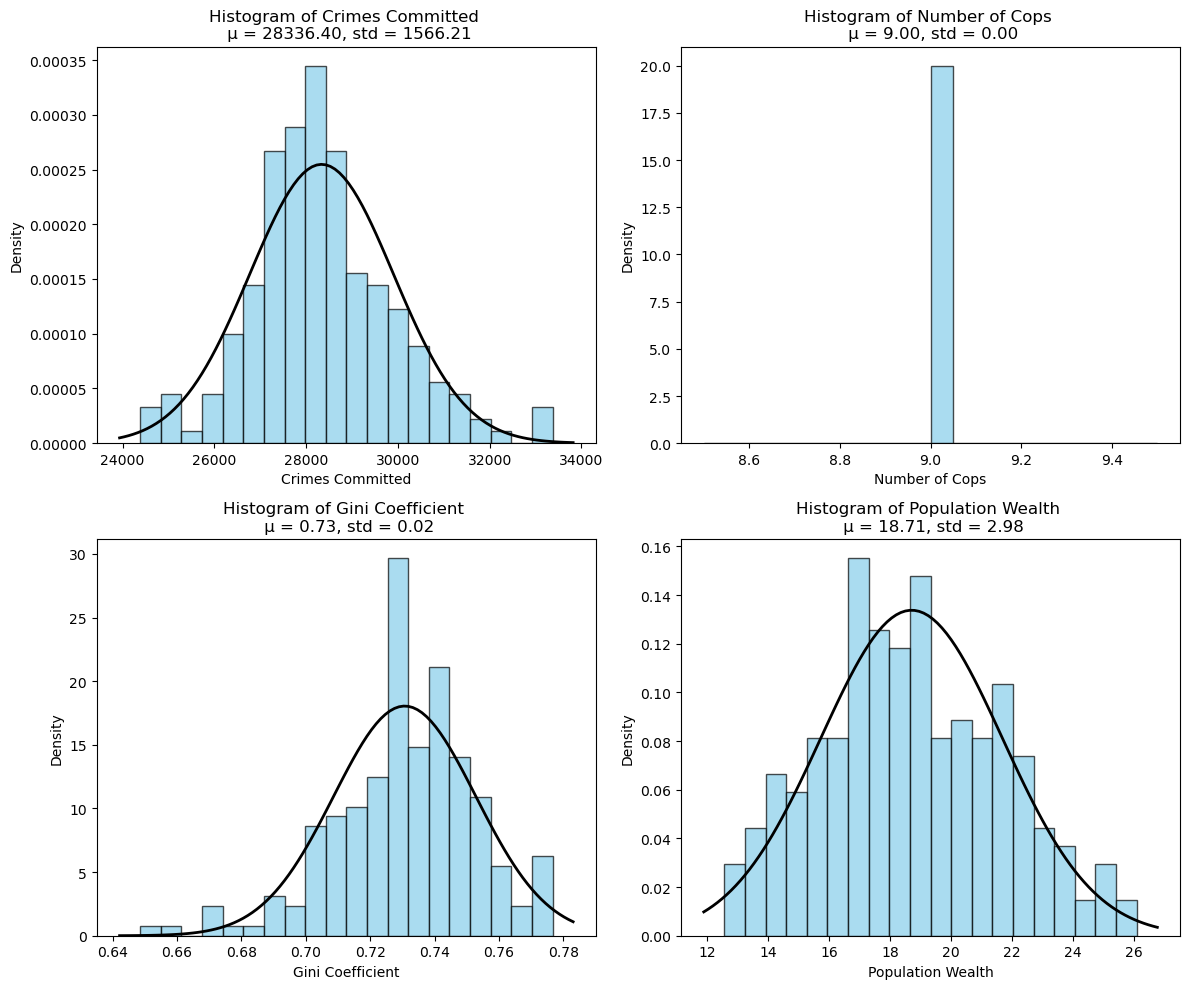

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.ravel()

for i, col in enumerate(columns_to_plot):
    mean_value_at_last_step = data_at_last_step.groupby(['iteration'])[col].mean().reset_index()

    # Calculate the mean and standard deviation for the normal distribution
    mu, std = norm.fit(mean_value_at_last_step[col].dropna())

    # Plot the histogram of the data
    n, bins, patches = axs[i].hist(mean_value_at_last_step[col].dropna(), bins=20, density=True, color='skyblue', edgecolor='black', alpha=0.7)

    # Create a range of values from min to max in a fine range
    xmin, xmax = axs[i].get_xlim()
    x = np.linspace(xmin, xmax, 100)

    # Calculate the normal distribution's PDF on the range
    p = norm.pdf(x, mu, std)

    # Plot the PDF line
    axs[i].plot(x, p, 'k', linewidth=2)
    title = f'μ = {mu:.2f}, std = {std:.2f}'
    axs[i].set_title(f'Histogram of {labels[col]} \n {title}')
    axs[i].set_xlabel(f'{labels[col]}')
    axs[i].set_ylabel('Density')

plt.tight_layout()
plt.show()

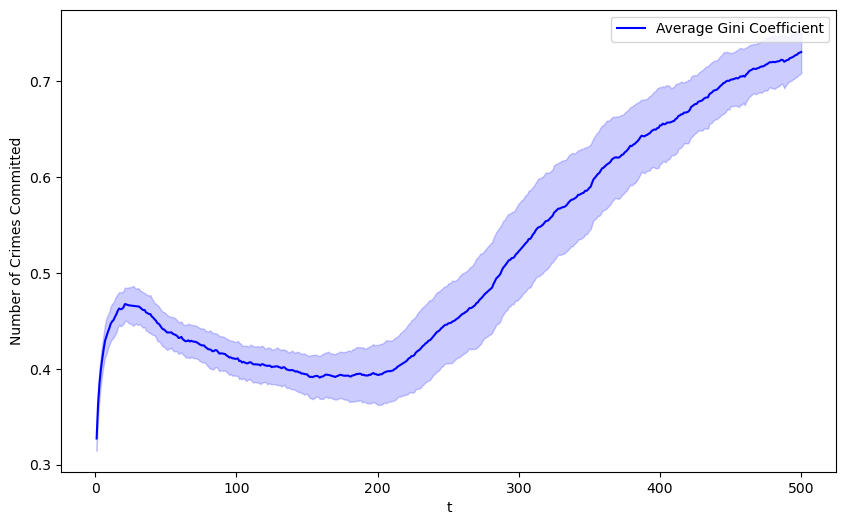

In [13]:
gini_per_step = default_data.groupby('Step')['gini_coeff'].agg(['mean', 'std'])
plt.figure(figsize=(10, 6))
plt.plot(gini_per_step.index, gini_per_step['mean'], label='Average Gini Coefficient', color='blue')
plt.fill_between(gini_per_step.index, 
                 gini_per_step['mean'] - gini_per_step['std'], 
                 gini_per_step['mean'] + gini_per_step['std'], 
                 color='blue', alpha=0.2)

plt.xlabel('t')
plt.ylabel('Number of Crimes Committed')
plt.legend()
plt.show()

# OFAT SA
One Factor at A Time (OFAT or OFaaT) SA is a method of testing the output variance of inputs one at a time. 

### Sentence Length
Analyze how varying sentence length would affect the model outputs

In [95]:
sentence_data = pd.read_csv('../results/vary_sentence_length_results.csv')

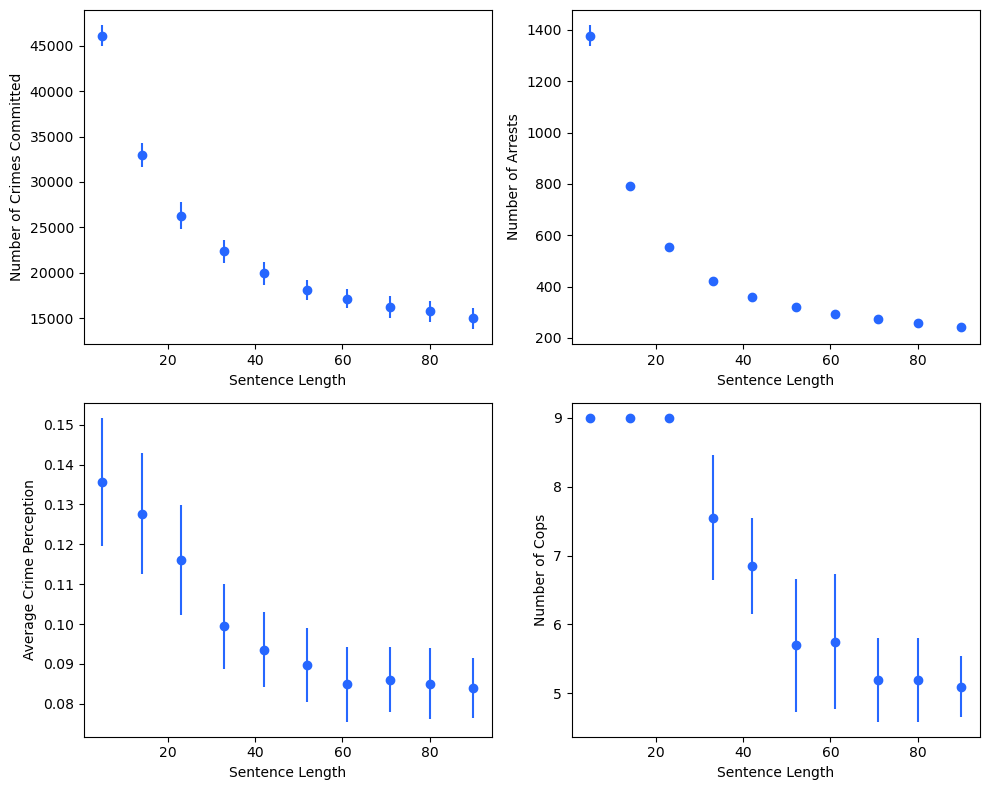

In [3]:
plot_ofat_final_step(sentence_data, 'sentence_length', 500)

In [110]:
sentence_data

,Step,num_cops,num_crimes_committed,num_arrests_made,tax_rate,total_stolen,total_trade_income,avg_wealth,total_wealth,avg_crime_perception,...,sentence_length,num_econ_agents,initial_cops,width,height,election_frequency,interaction_memory,risk_aversion_std,trading_skill_std,tax_per_cop
0,1,2,146,1,0.02,348.904058,1.671739,5.379733,1075.946504,0.016667,...,5,200,2,20,20,70,50,0.3,0.3,0.01
1,2,2,280,7,0.02,732.622311,4.693580,5.064579,1012.915714,0.040654,...,5,200,2,20,20,70,50,0.3,0.3,0.01
2,3,2,432,9,0.02,1133.720229,6.557515,4.868247,973.649436,0.045319,...,5,200,2,20,20,70,50,0.3,0.3,0.01
3,4,2,564,10,0.02,1477.752111,12.305759,4.759922,951.984494,0.044111,...,5,200,2,20,20,70,50,0.3,0.3,0.01
4,5,2,680,14,0.02,1835.013982,17.138790,4.631555,926.311004,0.052775,...,5,200,2,20,20,70,50,0.3,0.3,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,496,5,13488,242,0.05,15571.307801,1727.589146,0.096752,19.350359,0.078010,...,90,200,2,20,20,70,50,0.3,0.3,0.01
199996,497,5,13496,242,0.05,15571.557272,1727.974276,0.093743,18.748678,0.077810,...,90,200,2,20,20,70,50,0.3,0.3,0.01
199997,498,5,13512,242,0.05,15571.869517,1728.383521,0.090974,18.194726,0.077310,...,90,200,2,20,20,70,50,0.3,0.3,0.01
199998,499,5,13522,242,0.05,15572.280434,1728.742158,0.088159,17.631870,0.077210,...,90,200,2,20,20,70,50,0.3,0.3,0.01


In [118]:
avg_sentence_data = sentence_data.groupby(['Step', 'sentence_length']).mean().reset_index()

/var/folders/t0/9lmj5c1904g_2_gp5sk6gz180000gn/T/ipykernel_50294/3827992012.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_df['gini_coeff_binned'] = gini_bins
/var/folders/t0/9lmj5c1904g_2_gp5sk6gz180000gn/T/ipykernel_50294/3827992012.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_df['sentence_length_binned'] = risk_aversion_std_bins
/var/folders/t0/9lmj5c1904g_2_gp5sk6gz180000gn/T/ipykernel_50294/3827992012.py:11: FutureWarning: The default value of observed=False is deprecated an

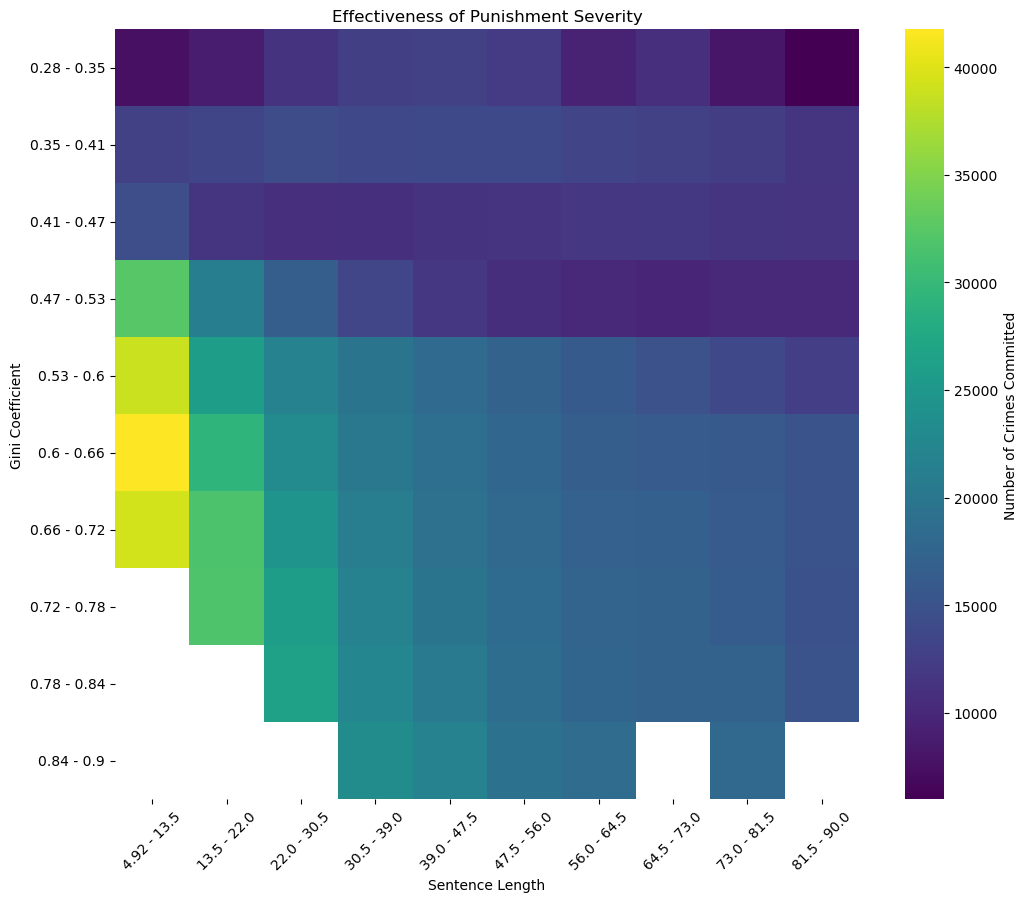

In [142]:
heatmap_df = sentence_data[['gini_coeff', 'sentence_length', 'num_crimes_committed']]

# Bin the data for the heatmap
gini_bins = pd.cut(heatmap_df['gini_coeff'], bins=10)
risk_aversion_std_bins = pd.cut(heatmap_df['sentence_length'], bins=10)

heatmap_df['gini_coeff_binned'] = gini_bins
heatmap_df['sentence_length_binned'] = risk_aversion_std_bins

# Create a pivot table for the heatmap
heatmap_data = heatmap_df.pivot_table(values='num_crimes_committed', 
                                      index='gini_coeff_binned', 
                                      columns='sentence_length_binned', 
                                      aggfunc=np.mean)

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_data, cmap='viridis', annot=False, fmt=".1f", cbar_kws={'label': 'Number of Crimes Committed'})
plt.title('Effectiveness of Punishment Severity')
plt.xlabel('Sentence Length')
plt.ylabel('Gini Coefficient')

# Update the axis labels with bin ranges
gini_labels = [f"{round(bin.left, 2)} - {round(bin.right, 2)}" for bin in heatmap_data.index.categories]
risk_aversion_std_labels = [f"{round(bin.left, 2)} - {round(bin.right, 2)}" for bin in heatmap_data.columns.categories]

plt.xticks(ticks=np.arange(len(risk_aversion_std_labels))+0.5, labels=risk_aversion_std_labels, rotation=45)
plt.yticks(ticks=np.arange(len(gini_labels))+0.5, labels=gini_labels, rotation=0)
plt.show()

### Standard deviation in the distribution of risk aversion
to analyze how homogeneity and diversity in agents' risk profiles would affect the dynamics

In [59]:
risk_data = pd.read_csv('../results/vary_risk_results.csv')

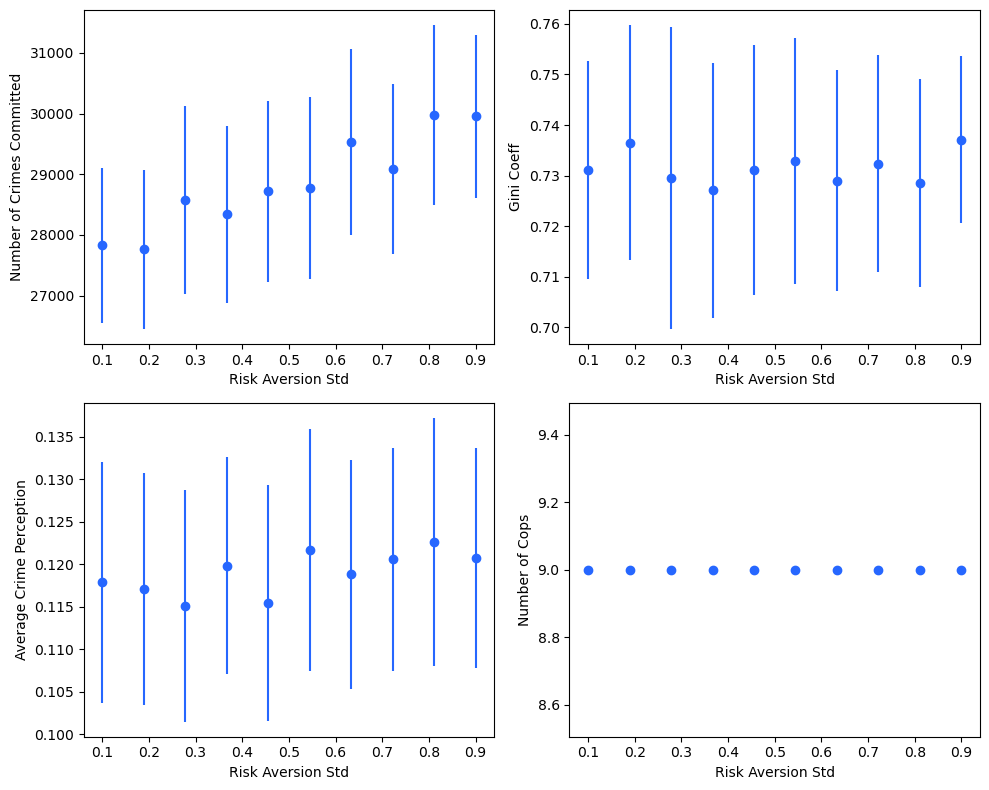

In [5]:
plot_ofat_final_step(risk_data, 'risk_aversion_std', 500)

### Heatmap
To show the interplay between risk tolerance, economic capability (trading skills), and how these factors together shape the voting outcomes for policing levels

/var/folders/t0/9lmj5c1904g_2_gp5sk6gz180000gn/T/ipykernel_50294/1043314268.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_df['gini_coeff_binned'] = gini_bins
/var/folders/t0/9lmj5c1904g_2_gp5sk6gz180000gn/T/ipykernel_50294/1043314268.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_df['risk_aversion_std_binned'] = risk_aversion_std_bins
/var/folders/t0/9lmj5c1904g_2_gp5sk6gz180000gn/T/ipykernel_50294/1043314268.py:11: FutureWarning: The default value of observed=False is deprecated 

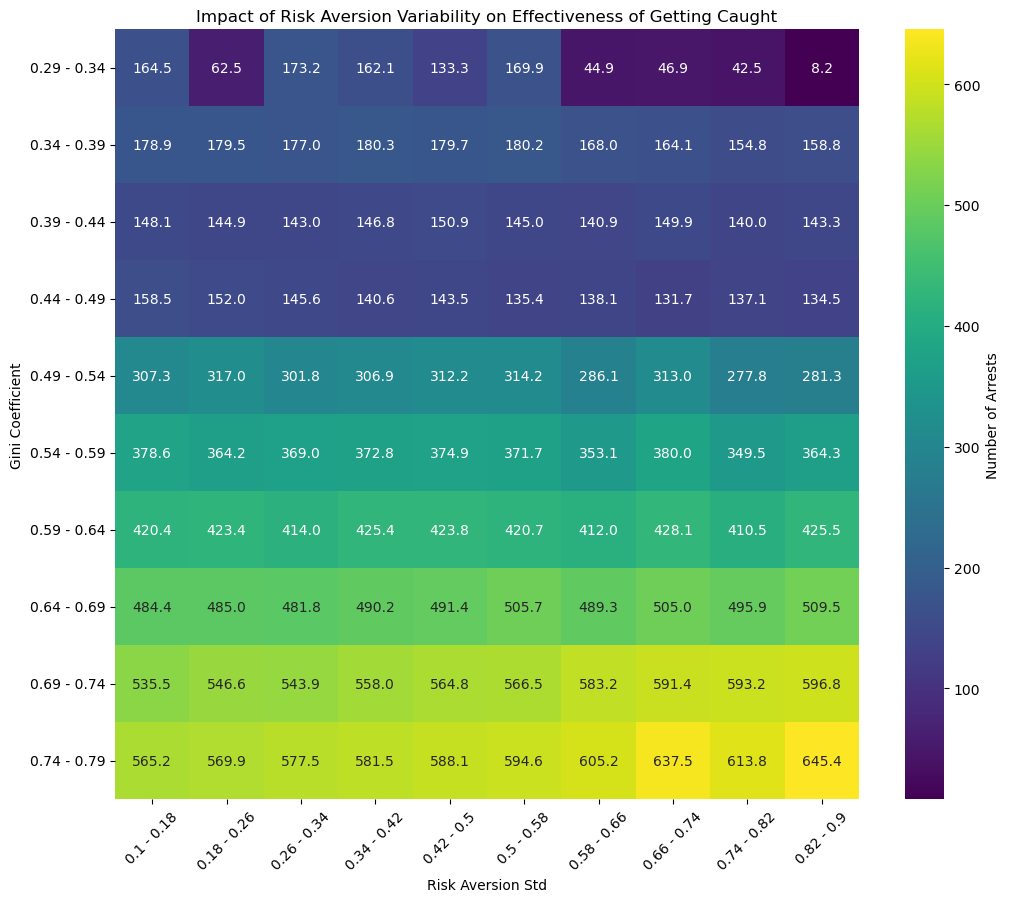

In [98]:
heatmap_df = risk_data[['gini_coeff', 'risk_aversion_std', 'num_arrests_made']]

# Bin the data for the heatmap
gini_bins = pd.cut(heatmap_df['gini_coeff'], bins=10)
risk_aversion_std_bins = pd.cut(heatmap_df['risk_aversion_std'], bins=10)

heatmap_df['gini_coeff_binned'] = gini_bins
heatmap_df['risk_aversion_std_binned'] = risk_aversion_std_bins

# Create a pivot table for the heatmap
heatmap_data = heatmap_df.pivot_table(values='num_arrests_made', 
                                      index='gini_coeff_binned', 
                                      columns='risk_aversion_std_binned', 
                                      aggfunc=np.mean)

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt=".1f", cbar_kws={'label': 'Number of Arrests'})
plt.title('Impact of Risk Aversion Variability on Effectiveness of Getting Caught')
plt.xlabel('Risk Aversion Std')
plt.ylabel('Gini Coefficient')

# Update the axis labels with bin ranges
gini_labels = [f"{round(bin.left, 2)} - {round(bin.right, 2)}" for bin in heatmap_data.index.categories]
risk_aversion_std_labels = [f"{round(bin.left, 2)} - {round(bin.right, 2)}" for bin in heatmap_data.columns.categories]

plt.xticks(ticks=np.arange(len(risk_aversion_std_labels))+0.5, labels=risk_aversion_std_labels, rotation=45)
plt.yticks(ticks=np.arange(len(gini_labels))+0.5, labels=gini_labels, rotation=0)
plt.show()

### Interaction Memory

In [29]:
memory_data = pd.read_csv('../results/vary_memory_results.csv')

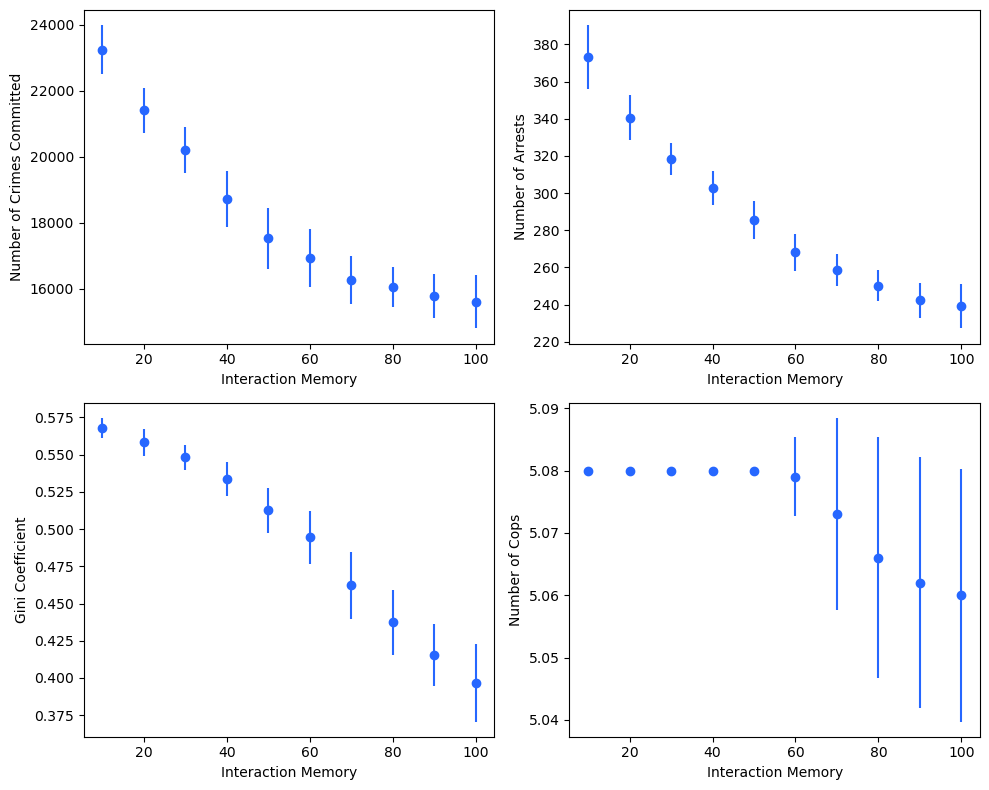

In [30]:
plot_ofat(memory_data, 'interaction_memory')

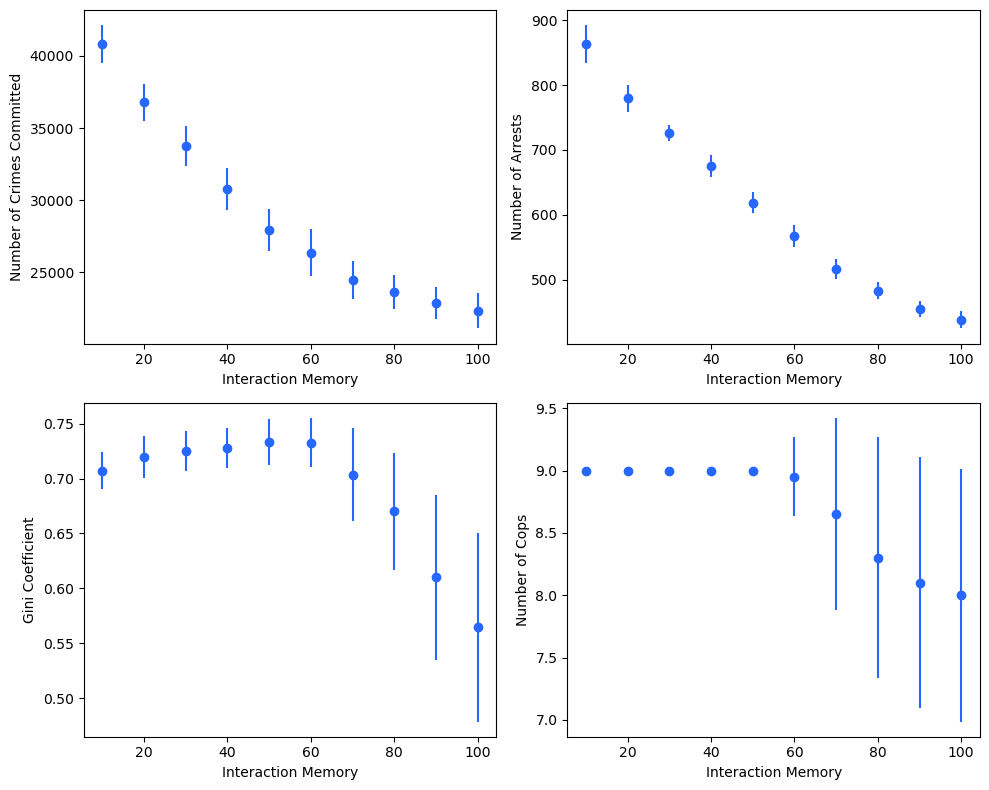

In [31]:
plot_ofat_final_step(memory_data, 'interaction_memory', 500)

### Election Frequency

In [32]:
election_data = pd.read_csv('../results/vary_election_results.csv')

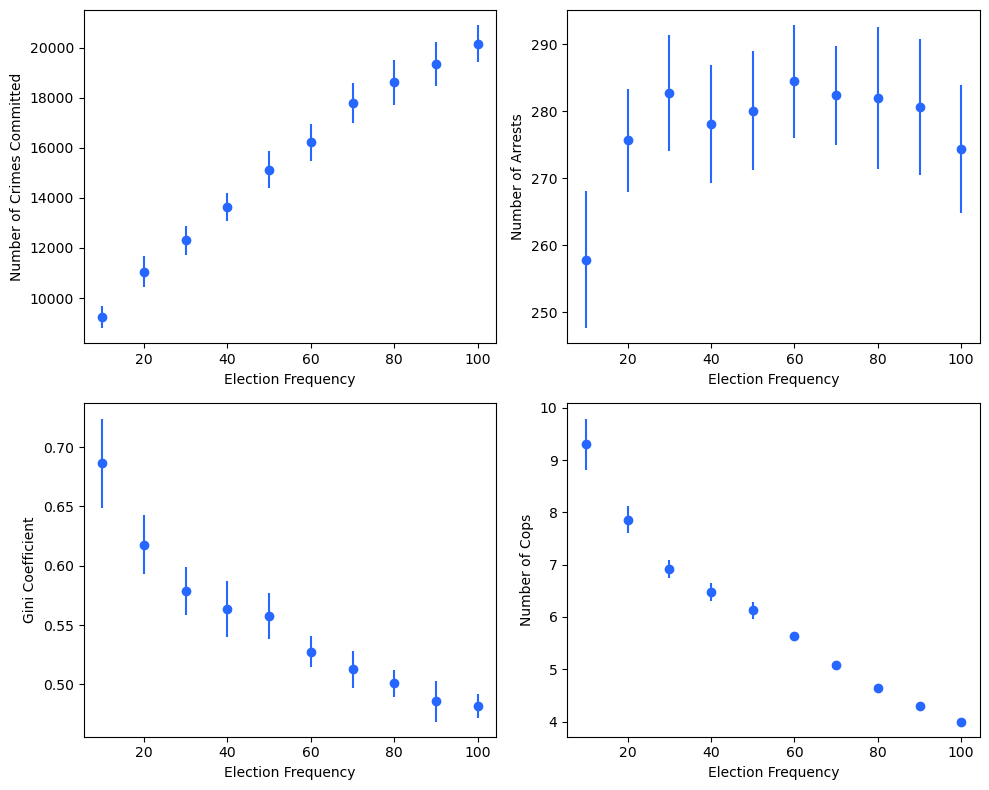

In [33]:
plot_ofat(election_data, 'election_frequency')

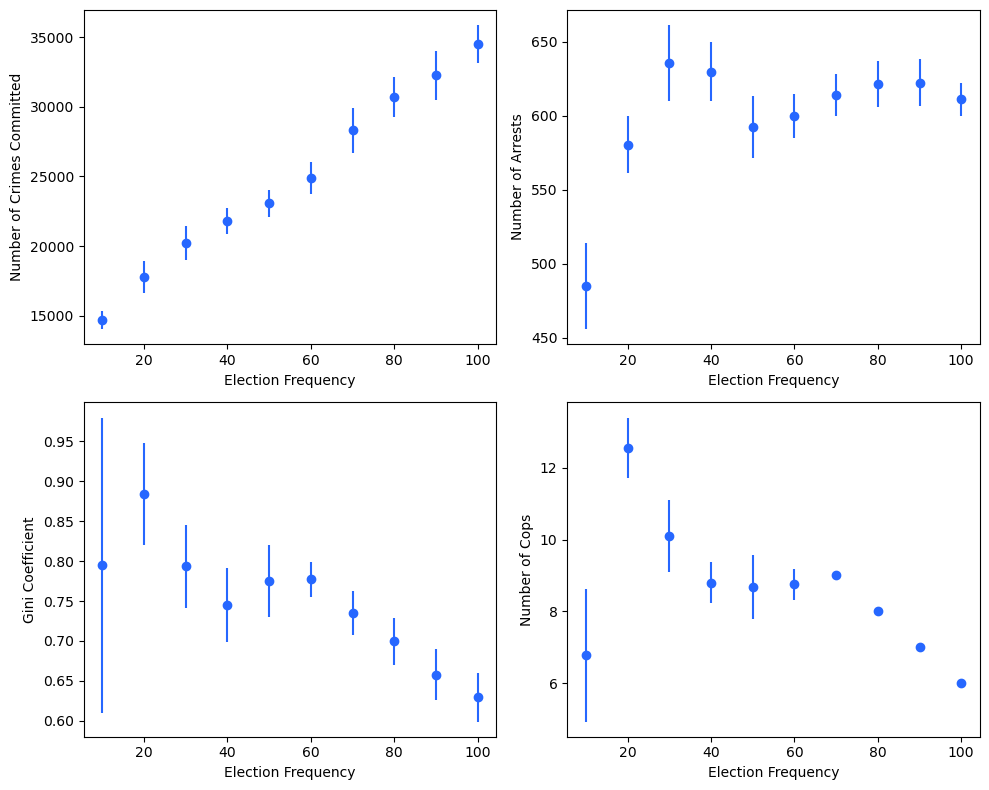

In [34]:
plot_ofat_final_step(election_data, 'election_frequency', 500)

### Trading Skill

In [2]:
trade_data = pd.read_csv('../results/vary_trading_results.csv')

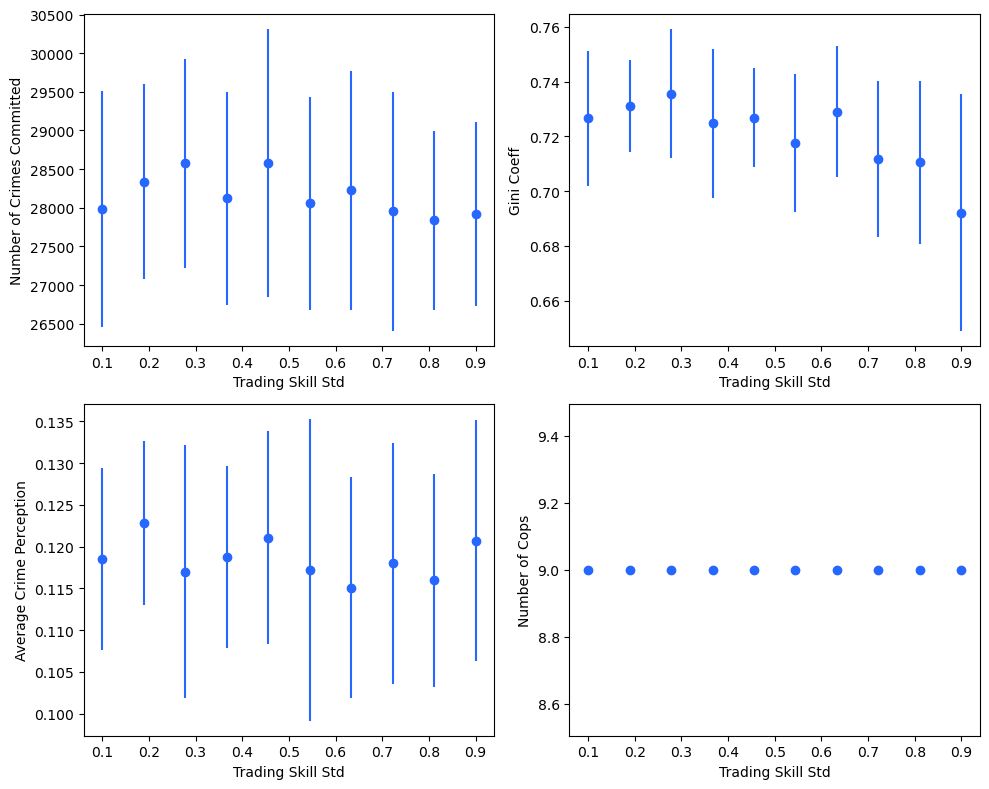

In [3]:
plot_ofat_final_step(trade_data , 'trading_skill_std', 500)

### Heatmap
To show the interplay between risk tolerance, economic capability (trading skills), and how these factors together shape the voting outcomes for policing levels

/var/folders/t0/9lmj5c1904g_2_gp5sk6gz180000gn/T/ipykernel_50294/330953715.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_df['gini_coeff_binned'] = gini_bins
/var/folders/t0/9lmj5c1904g_2_gp5sk6gz180000gn/T/ipykernel_50294/330953715.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_df['trading_skill_std_binned'] = risk_aversion_std_bins
/var/folders/t0/9lmj5c1904g_2_gp5sk6gz180000gn/T/ipykernel_50294/330953715.py:11: FutureWarning: The default value of observed=False is deprecated and

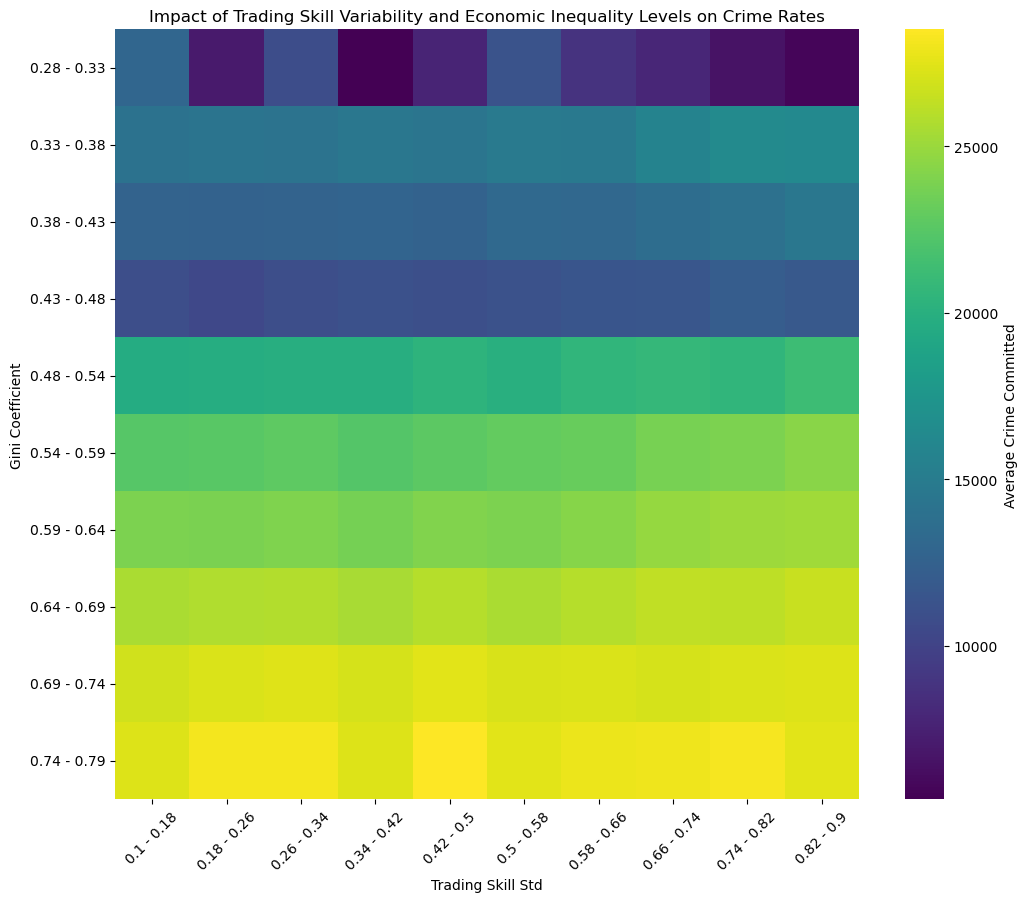

In [133]:
heatmap_df = trade_data[['gini_coeff', 'trading_skill_std', 'num_crimes_committed']]

# Bin the data for the heatmap
gini_bins = pd.cut(heatmap_df['gini_coeff'], bins=10)
risk_aversion_std_bins = pd.cut(heatmap_df['trading_skill_std'], bins=10)

heatmap_df['gini_coeff_binned'] = gini_bins
heatmap_df['trading_skill_std_binned'] = risk_aversion_std_bins

# Create a pivot table for the heatmap
heatmap_data = heatmap_df.pivot_table(values='num_crimes_committed', 
                                      index='gini_coeff_binned', 
                                      columns='trading_skill_std_binned', 
                                      aggfunc=np.mean)

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_data, cmap='viridis', annot=False, fmt=".1f", cbar_kws={'label': 'Average Crime Committed'})
plt.title('Impact of Trading Skill Variability and Economic Inequality Levels on Crime Rates')
plt.xlabel('Trading Skill Std')
plt.ylabel('Gini Coefficient')

# Update the axis labels with bin ranges
gini_labels = [f"{round(bin.left, 2)} - {round(bin.right, 2)}" for bin in heatmap_data.index.categories]
risk_aversion_std_labels = [f"{round(bin.left, 2)} - {round(bin.right, 2)}" for bin in heatmap_data.columns.categories]

plt.xticks(ticks=np.arange(len(risk_aversion_std_labels))+0.5, labels=risk_aversion_std_labels, rotation=45)
plt.yticks(ticks=np.arange(len(gini_labels))+0.5, labels=gini_labels, rotation=0)
plt.show()

### Tax Rate for Cops

In [37]:
tax_data = pd.read_csv('../results/vary_tax_results.csv')

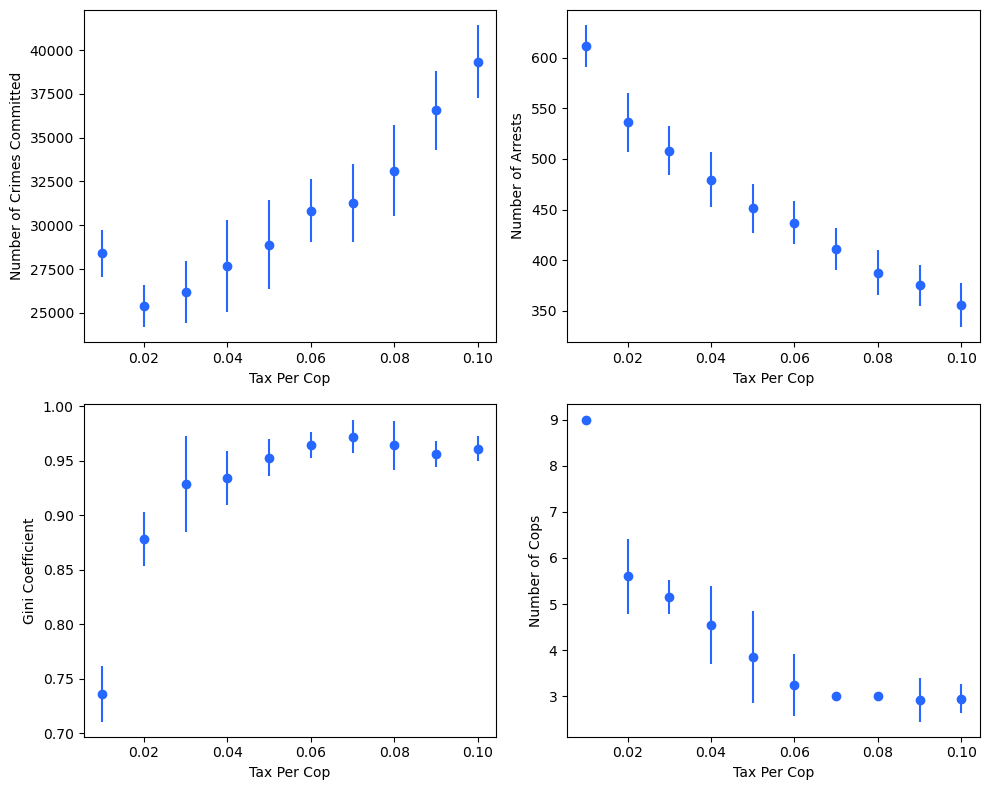

In [38]:
plot_ofat_final_step(tax_data , 'tax_per_cop', 500)